<a href="https://colab.research.google.com/github/PRAISE-KING/wk-7-ai-for-software-engineering/blob/main/COMPAS_Recidivism_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
import os

# Define the URL and the target directory
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
target_dir = "/usr/local/lib/python3.11/dist-packages/aif360/data/raw/compas"
target_file = os.path.join(target_dir, "compas-scores-two-years.csv")

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Download the file
response = requests.get(url)
response.raise_for_status() # Raise an exception for bad status codes
with open(target_file, 'wb') as f:
    f.write(response.content)

print(f"Downloaded {url} to {target_file}")

Downloaded https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv to /usr/local/lib/python3.11/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv


In [4]:
# 3. Load COMPAS Dataset from AIF360
from aif360.datasets import CompasDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [5]:

# Load dataset
dataset = CompasDataset()
dataset_orig = dataset.copy()

In [6]:

# Define privileged/unprivileged groups
privileged_groups = [{'race': 1}]      # Caucasian
unprivileged_groups = [{'race': 0}]    # African-American

In [7]:
# Split dataset
train, test = dataset_orig.split([0.7], shuffle=True)

In [8]:
# Apply reweighing to mitigate bias
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
train_transf = RW.fit_transform(train)

In [9]:
# Train Random Forest model
X_train = train_transf.features
y_train = train_transf.labels.ravel()

X_test = test.features
y_test = test.labels.ravel()

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [10]:
# Add predictions to test dataset
test_pred = test.copy()
test_pred.labels = y_pred.reshape(-1, 1)

In [11]:
# 4. Bias Metrics & Visualization
metric = ClassificationMetric(test, test_pred,
                               unprivileged_groups=unprivileged_groups,
                               privileged_groups=privileged_groups)

In [13]:
# Print false positive rates
print("False Positive Rate (African-American):", metric.false_positive_rate(privileged=False))
print("False Positive Rate (Caucasian):", metric.false_positive_rate(privileged=True))

False Positive Rate (African-American): 0.3708609271523179
False Positive Rate (Caucasian): 0.4583333333333333


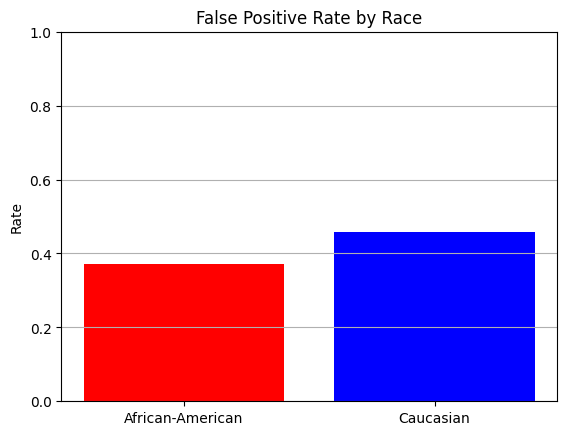

In [15]:
# Plot FPR disparity
labels = ['African-American', 'Caucasian']
values = [metric.false_positive_rate(privileged=False),
          metric.false_positive_rate(privileged=True)]

plt.bar(labels, values, color=['red', 'blue'])
plt.title("False Positive Rate by Race")
plt.ylabel("Rate")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()